[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/scVI_Batch_Correction.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025.git
%cd /content/OP_2025/

# Download Data

In [ ]:
!mkdir omics_adata
!wget -O omics_adata/rat_RNA_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1


# Install Packages

In [ ]:
!pip install -qr requirements.txt 

In [ ]:
# import packages

import os, sys
from pathlib import Path

# numbers
import numpy as np
import pandas as pd

# sc
import scanpy as sc
import anndata
import scvi

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWar

# Metadata Loading

In [3]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

## Initial data loading

In [ ]:
adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")

adata.obs.time = adata.obs.time.astype('int')

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 861 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name', 'log1p'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

# scVI model Setup

In [5]:
scvi.model.SCVI.setup_anndata(adata, 
                              layer="counts", 
                              batch_key = 'tissue',
                              categorical_covariate_keys=['sex'], 
)

In [6]:
scvi_ref = scvi.model.SCVI(adata,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True)
scvi_ref.train()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottlene

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


# Create PCA from latent space representation

In [7]:
SCVI_LATENT_KEY = "X_scVI"

latent = scvi_ref.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(861, 10)

In [8]:
X_pca = sc.tl.pca(adata.obsm[SCVI_LATENT_KEY], svd_solver='arpack')
X_pca = pd.DataFrame(X_pca
                    )
X_pca.columns = ['PC' + str(x+1) for x in X_pca.columns]
X_pca['tissue'] = adata.obs.tissue.values
X_pca['sex'] = adata.obs.sex.values
X_pca['time'] = adata.obs.time.values
X_pca['nid'] = adata.obs.nid.values

In [9]:
X_pca.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'tissue',
       'sex', 'time', 'nid'],
      dtype='object')

# Plot PCAs

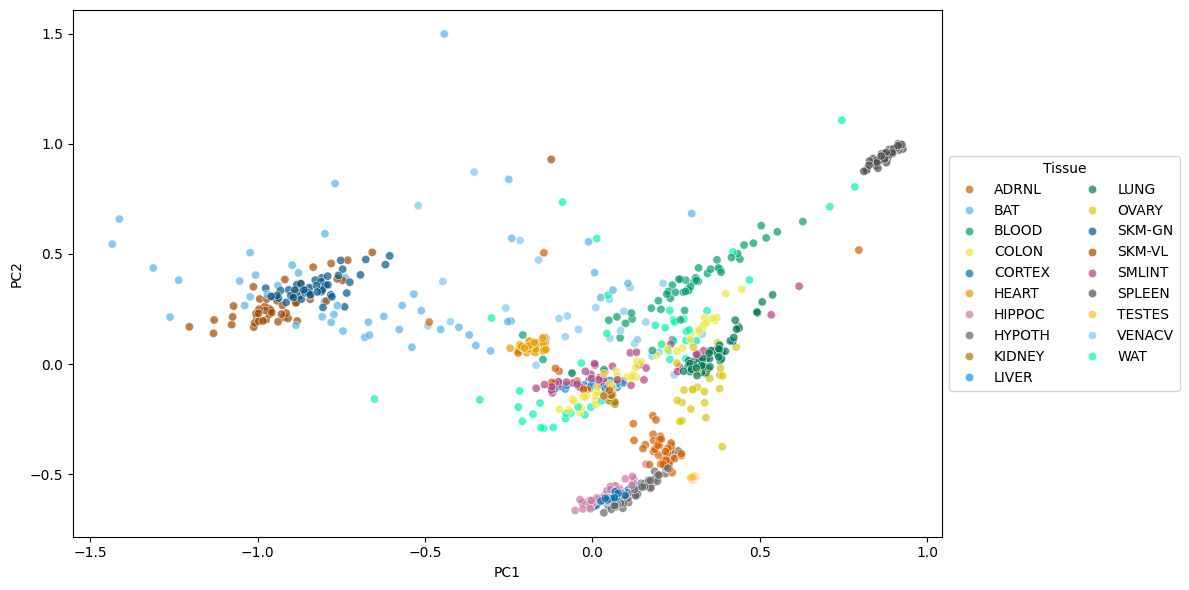

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.scatterplot(X_pca, x='PC1', y='PC2', hue='tissue', palette = color_dict, alpha=.7)
handles, labels = g.axes.get_legend_handles_labels()
g.legend().remove()
ax.legend(handles, labels, ncol=2, loc='center left', bbox_to_anchor=(1, .5),
        title='Tissue')
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_3a.png')
plt.show()

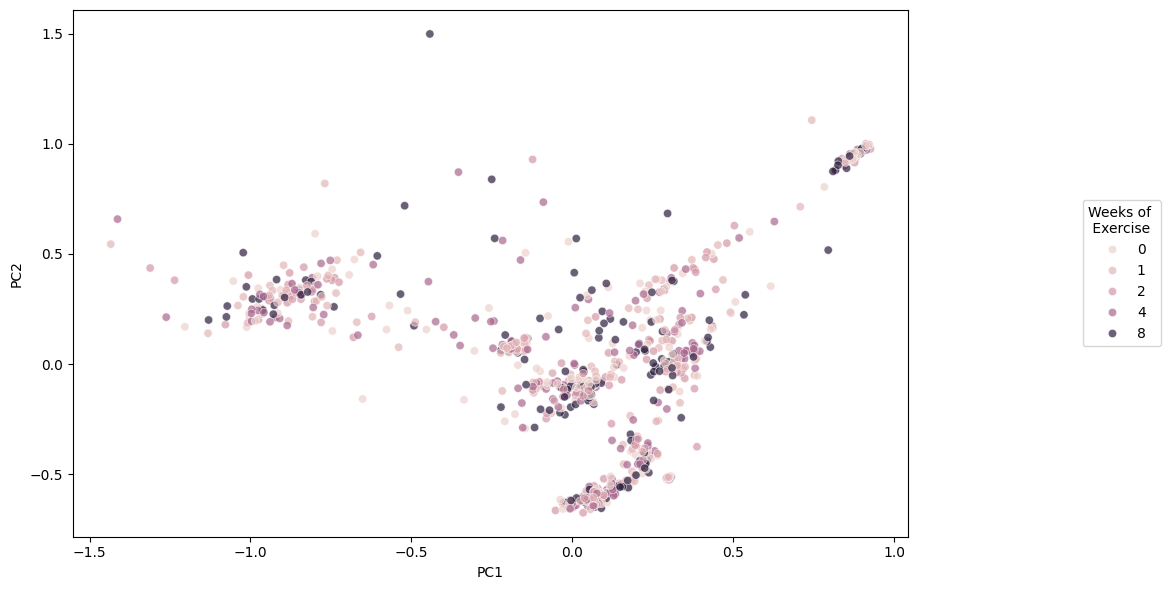

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.scatterplot(X_pca, x='PC1', y='PC2', hue='time', alpha=.7)
handles, labels = g.axes.get_legend_handles_labels()
g.legend().remove()
ax.legend(handles, labels, ncol=1, loc='center left', bbox_to_anchor=(1.2, .5),
        title='Weeks of \n Exercise')
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_3b.png')
plt.show()

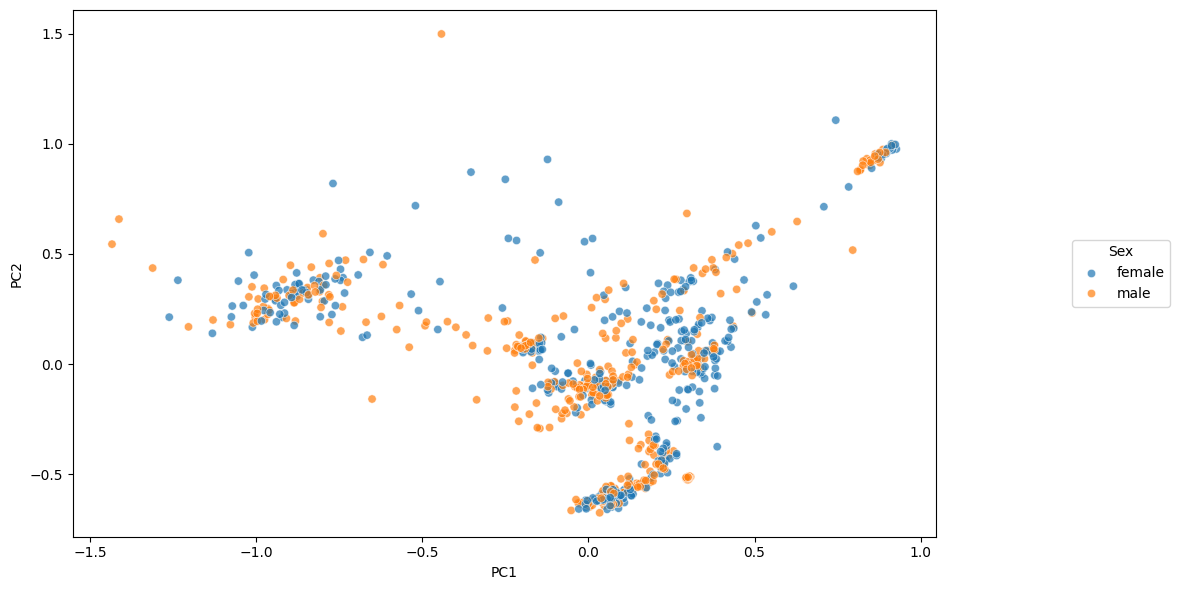

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.scatterplot(X_pca, x='PC1', y='PC2', hue='sex', alpha=.7)
handles, labels = g.axes.get_legend_handles_labels()
g.legend().remove()
ax.legend(handles, labels, ncol=1, loc='center left', bbox_to_anchor=(1.15, .5),
        title='Sex')
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_3c.png')
plt.show()

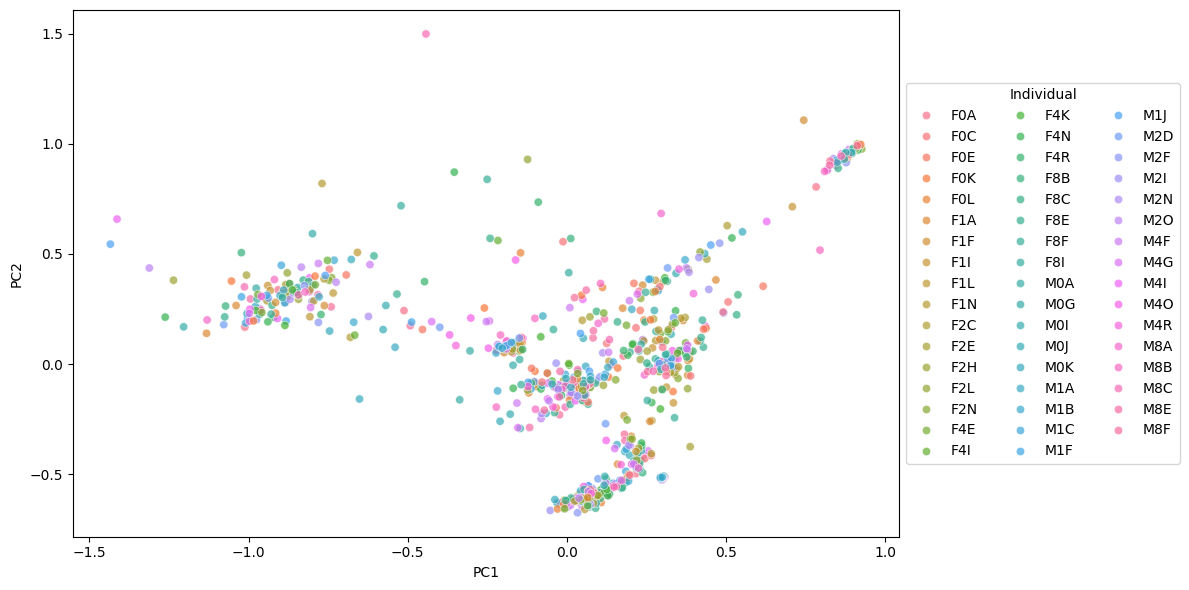

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.scatterplot(X_pca, x='PC1', y='PC2', hue='nid', alpha=.7)
handles, labels = g.axes.get_legend_handles_labels()
g.legend().remove()
ax.legend(handles, labels, ncol=3, loc='center left', bbox_to_anchor=(1, .5),
        title='Individual')
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_3d.png')
plt.show()